In [420]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Display an image from a local file
img__scheme = "molecules.png"

# Table of Contents

1. [Introduction](#introduction)
2. [System Description](#system-description)
3. [Properties](#props)
    1. [Aspen PLUS](#aspen-phys)
    2. [Hydrogen Solubility: Extrapolation of literature data](#h2-extrapolation)
    3. [Hydrogen Solubility: Sensitivity Analysis](#h2-sensitivity)
4. [Hydrogen Concentration in Liquid Phase](#H2-liquid-phase)
5. [Diffusion of Hydrogen to Catalyst Surface](#diffusion-cat-surf)
    1. [Mean Void Fraction](#mean-void-frac)   
    2. [Influence of Pellet Geometry on Mean Void Fraction](#mean-void-frac-sensitivity) 
    
To be continued

<a id="introduction"></a>
# Introduction

Unsaturated fatty alcohols are valuable products derived from the hydrogenolysis of fatty acid methyl esters (FAME), with applications in detergents, leather processing, and as industrial lubricants. Industrially, these alcohols are typically produced in slurry-type or fixed-bed trickle reactors. The fixed-bed trickle technology employs zinc chromate catalysts in the form of 3 mm pellets, operating under conditions of 230 bar and temperatures ranging from 270 to 300 °C.

In my dissertation project, the focus is on developing a novel catalyst to replace zinc chromate, aiming to improve efficiency and sustainability. During the research, data was collected on approximately 60 different materials. The reaction mechanism involves hydrogen dissolving in the FAME, diffusing through the liquid to the catalyst surface, and then reacting at the surface. Although the detailed description of each step is complex, this document provides a mathematical and conceptual overview of the entire process.

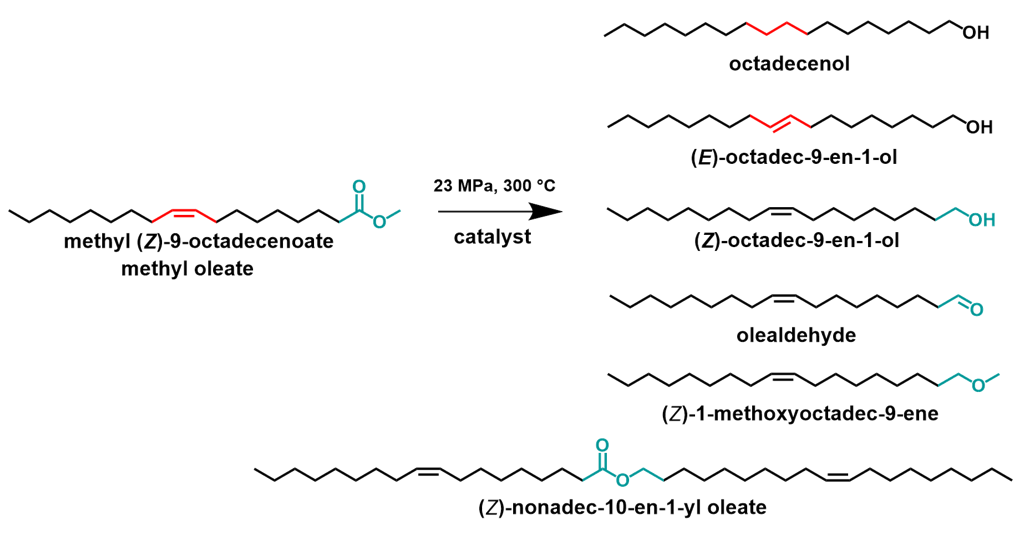

In [421]:
Image(filename=img__scheme, width=750, height=200)

<a id="system-description"></a>
# System Description
### Reactants

| **Reactant**        | **Formula**  | **Configuration**   |
|---------------------|--------------|---------------------|
| Methyl Oleate        | C₁₉H₃₆O₂     | cis (C18:1)         |
| Methyl Palmitate     | C₁₇H₃₄O₂     | Saturated (C16:0)   |
| Methyl Stearate      | C₁₉H₃₈O₂     | Saturated (C18:0)   |
| Methyl Linoleate     | C₁₉H₃₄O₂     | cis (C18:2)         |
| Hydrogen             | H₂           | -                   |

### Products

| **Product**         | **Formula**  | **Configuration**   |
|---------------------|--------------|---------------------|
| Oleylalcohol         | C₁₈H₃₆O      | cis (C18:1)         |
| Elaidylalcohol       | C₁₈H₃₆O      | trans (C18:1)       |
| Cetylalcohol         | C₁₆H₃₄O      | Saturated (C16:0)   |
| Stearylalcohol       | C₁₈H₃₈O      | Saturated (C18:0)   |
| Methanol             | CH₄O         | -                   |

### Process Conditions & Reactor Geometry

In [422]:
# Reaction Conditions
p = 230 # [bar]
T = 270 # [°C]

# Flowrates
V_cm3 = 27.5 # [cm3/h] volumetric flow through the plug flow reactor
V_gas = 0.4 # [Nm3/h] volumetric flow through the plug flow reactor

# Catalyst
m_cat = 144 # [g] arbitrary number
A_cat = 44 # [m2/g] specific surface of the catalyst, arbitrary

# Reactor geometry
d_tube = 0.02 # [m] reactor inner diameter
d_thermowell = 0.005 # [m] thermowell tube outer diameter
A = math.pi*((d_tube/2)**2-(d_thermowell/2)**2) # [m2] effective cross-sectional area

# Catalyst bed
V = 120 # [cm3] Catalyst bed volume

<a id="props"></a>
# Properties
<a id="aspen-phys"></a>
##  Aspen Plus

Due to the limited availability of experimental data, an Aspen simulation was conducted to estimate the chemical properties of the system's components. The simulation employed the NRTL method for activity coefficients and the Wilke-Chang-Lee method for diffusivity. The following properties were simulated:
- Density
- Viscosity
- H2 Diffusivity
- H2 Solubility

In [450]:
# Load data from the Excel sheet with Aspen Output
df_prop=pd.read_excel("Aspen Output 3.xlsx", sheet_name="master")
df_h2_sol=pd.read_excel("Aspen Output 3.xlsx", sheet_name="Solubility_mass")
# Save it to csv
df_h2_sol.to_csv("h2_sol.csv")

In [451]:
# Example renaming dictionary: {'old_column_name': 'new_column_name'}
rename_dict = {
    'METHYL-OLEATE': "_MeOleate",
    'METHYL-ELAIDATE': "_MeElaidate",
    'METHYL-STEARATE': "_MeStearate",
    'METHYL-PALMITATE': "_MePalmitate",
    '9-OCTADECEN-1-OL.-(Z)-':"_OleylAlcohol",
    'ELAIDYL-ALCOHOL':"_ElaidylAlcohol",
    '1-OCTADECANOL':"_StearylAlcohol",
    '1-HEXADECANOL':"_CetylAlcohol",
    'LINOLEYL-ALCOHOL':"_LinoleylAlcohol",
    'METHYL-LINOLEATE':"_MeLinoleate",
    "METHANOL":"_Methanol",
    'HYDROGEN':"_H2"
}
# Rename columns in df_prop
df_prop = df_prop.rename(columns=rename_dict)

In [452]:
# List of components (these are the column names in your dataframe for the respective components)
components = ['_MeOleate', '_MeElaidate', '_MeStearate', '_MePalmitate', 
              '_OleylAlcohol', '_ElaidylAlcohol', '_StearylAlcohol', 
              '_CetylAlcohol', '_Methanol', '_H2']

# List of available properties (this list can be extended as needed)
available_properties = df_prop["Property"].unique()

# Function to get a specific property (e.g., density, viscosity) based on temperature and pressure
def get_property(df, temp, pres, property_type):
    if property_type not in available_properties:
        raise ValueError(f"Property {property_type} is not available. Choose from {available_properties}")

    property_values = {}
    for component in components:
        # Filter by property type, temperature, and pressure
        row = df[(df['Property'] == property_type) & (df['TEMP_C'] == temp) & (df['PRES_bar'] == pres)]
        if not row.empty:
            # Store the property value in the dictionary using a key format like 'rho_MeOleate' or 'visc_MeOleate'
            property_values[f'{property_type.split("_")[0]}{component}'] = row[component].values[0]
        else:
            property_values[f'{property_type.split("_")[0]}{component}'] = None  # If no match is found
    
    return property_values

<a id="h2-extrapolation"></a>
## Hydrogen Solubility: Extrapolation of literature data

To verify hydrogen solubility, the simulated solubility was compared to data reported in the literature.

This code fits experimental data from the literature representing the relationship between pressure and solubility of a substance. The experimental data consists of pressure values (in MPa) and corresponding solubility values.

<small>Source:<small/>
    
<small>_Zhang X, Dong T, Wu Z, Jing Y, Yu D, Zhang H, Du J, Wang L. Soybean Oil Treatment Using the Dissolving Curve Equation of Hydrogen. J Oleo Sci. 2021 Sep 4;70(9):1231-1238. doi: 10.5650/jos.ess21065. Epub 2021 Aug 6. PMID: 34373403._<small/>


### Data Fitting

Using polynomial regression, the code fits a polynomial curve to the experimental data. The degree of the polynomial can be adjusted to best fit the data. The fitted curve represents the relationship between pressure and solubility based on the experimental data.

### Extrapolation

After fitting the polynomial curve, the code provides a function to extrapolate solubility values for pressure values beyond those present in the experimental data. This extrapolation allows us to estimate the solubility of the substance at higher pressure levels, which may not have been directly measured in the experiments.

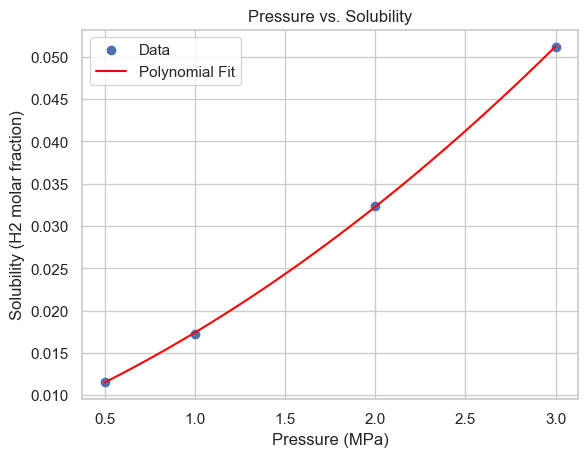

In [453]:
# Given data
pressures = np.array([0.5, 1.0, 2.0, 3.0])  # Pressure in MPa
solubilities = np.array([0.0116, 0.0172, 0.0324, 0.0512])  # Solubility

# Fit polynomial curve
degree = 2  # Degree of the polynomial (you can adjust this)
coefficients = np.polyfit(pressures, solubilities, degree)
poly_fit = np.poly1d(coefficients)

# Generate points for plotting the curve
pressure_range = np.linspace(min(pressures), max(pressures), 100)
solubility_fit = poly_fit(pressure_range)

# Plot the data and the fitted curve
plt.scatter(pressures, solubilities, label='Data')
plt.plot(pressure_range, solubility_fit, color='red', label='Polynomial Fit')
plt.xlabel('Pressure (MPa)')
plt.ylabel('Solubility (H2 molar fraction)')
plt.title('Pressure vs. Solubility')
plt.legend()
plt.grid(True)
plt.show()

In [454]:
# Generate points for plotting the curve
def extrapolate_pressure_to_solubility(pressure, coefficients):
    """
    Extrapolate solubility based on pressure using a polynomial fit.

    Args:
        pressure (float or array-like): Pressure value(s) to extrapolate.
        coefficients (array-like): Coefficients of the polynomial fit.

    Returns:
        float or array-like: Extrapolated solubility value(s).
    """
    # Create polynomial function from coefficients
    poly_fit = np.poly1d(coefficients)
    
    # Extrapolate solubility
    solubility = poly_fit(pressure)
    
    return solubility

pressure_to_extrapolate = 23  # Pressure to extrapolate
extrapolated_solubility = extrapolate_pressure_to_solubility(pressure_to_extrapolate, coefficients)
print(f"At pressure={pressure_to_extrapolate} MPa, extrapolated solubility={extrapolated_solubility}")
print("The extrapolation provided solubility above reasonable limit. Therefore this approach is abandoned.")

At pressure=23 MPa, extrapolated solubility=1.290897487437185
The extrapolation provided solubility above reasonable limit. Therefore this approach is abandoned.


<a id="h2-sensitivity"></a>
## Hydrogen Solubility: Sensitivity Analysis

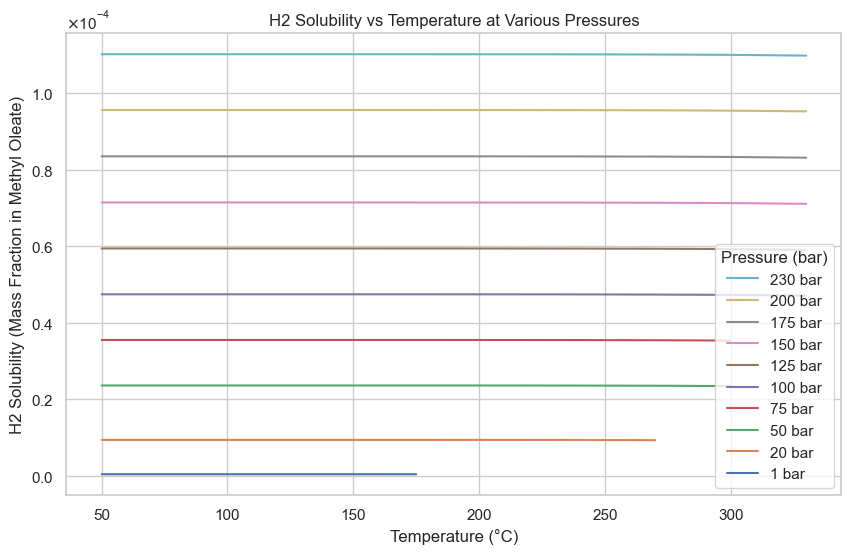

In [455]:
# Group data by pressure
pressures = df_h2_sol['PRES_bar'].unique()

# Plot solubility for each pressure
plt.figure(figsize=(10, 6))

lines = []
labels = []

# Plot and store lines and labels
for pressure in pressures:
    subset = df_h2_sol[df_h2_sol['PRES_bar'] == pressure]
    line, = plt.plot(subset['TEMP_C'], subset['H2FRA_mass_Me_Oleate'], label=f'{pressure} bar')
    lines.append(line)
    labels.append(f'{pressure} bar')

# Add labels and title
plt.xlabel('Temperature (°C)')
plt.ylabel('H2 Solubility (Mass Fraction in Methyl Oleate)')
plt.title('H2 Solubility vs Temperature at Various Pressures')

# Reverse the order of lines and labels for the legend
plt.legend(lines[::-1], labels[::-1], title='Pressure (bar)')

# Format y-axis in scientific notation
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.grid(True)

# Show the plot
plt.show()

And less of the temperature:

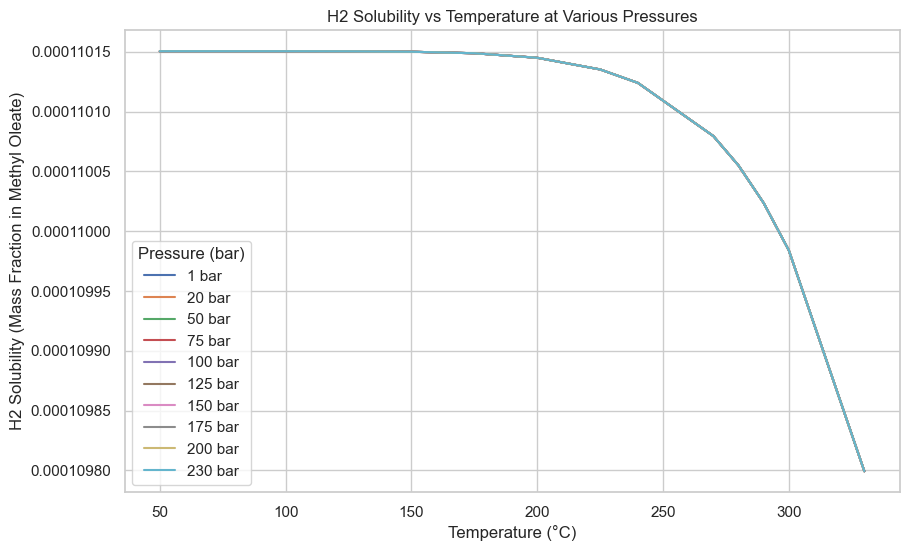

Diffusivity simulated in Aspen PLUS is considered for fruther calculations.


In [456]:
# Group data by pressure
pressures = df_h2_sol['PRES_bar'].unique()

# Plot solubility for each pressure
plt.figure(figsize=(10, 6))

for pressure in pressures:
    subset = df_h2_sol[df_h2_sol['PRES_bar'] == 230]
    plt.plot(subset['TEMP_C'], subset['H2FRA_mass_Me_Oleate'], label=f'{pressure} bar')

# Add labels and title
plt.xlabel('Temperature (°C)')
plt.ylabel('H2 Solubility (Mass Fraction in Methyl Oleate)')
plt.title('H2 Solubility vs Temperature at Various Pressures')
plt.legend(title='Pressure (bar)')
plt.grid(True)

# Show the plot
plt.show()

print("Diffusivity simulated in Aspen PLUS is considered for fruther calculations.")

<a id="H2-liquid-phase"></a>
## Hydrogen Concentration in Liquid Phase

Based on the discussion above, the solubility is assessed from the "Database" of Aspen PLUS generated properties. The solubility is calculated according to Henry's law, with NRTL (Non-Random Two-Liquid model).

In [457]:
def get_h2_solubility(df, temp, pres, solvent):
    """
    Get the hydrogen solubility based on temperature, pressure, and solvent.

    Parameters:
        df (pd.DataFrame): DataFrame containing the solubility data.
        temp (float): Temperature in Celsius.
        pres (float): Pressure in bar.
        solvent (str): Solvent name matching column suffix in the DataFrame.

    Returns:
        float: Hydrogen solubility value.
    """
    # Validate solvent
    solubility_column = f"H2FRA_mass_{solvent}"
    if solubility_column not in df.columns:
        raise ValueError(f"Solvent '{solvent}' not found in DataFrame.")

    # Adjust temperature if out of range
    if temp < df['TEMP_C'].min():
        print(f"Temperature {temp}°C is below range. Using lowest value: {df['TEMP_C'].min()}°C.")
        temp = df['TEMP_C'].min()
    elif temp > df['TEMP_C'].max():
        print(f"Temperature {temp}°C is above range. Using highest value: {df['TEMP_C'].max()}°C.")
        temp = df['TEMP_C'].max()

    # Adjust pressure if out of range
    if pres < df['PRES_bar'].min():
        print(f"Pressure {pres} bar is below range. Using lowest value: {df['PRES_bar'].min()} bar.")
        pres = df['PRES_bar'].min()
    elif pres > df['PRES_bar'].max():
        print(f"Pressure {pres} bar is above range. Using highest value: {df['PRES_bar'].max()} bar.")
        pres = df['PRES_bar'].max()

    # Filter rows close to the specified temp and pres
    filtered_df = df[(df['TEMP_C'] == temp) & (df['PRES_bar'] == pres)]

    # If exact match exists
    if not filtered_df.empty:
        return filtered_df.iloc[0][solubility_column]

    # Otherwise, interpolate solubility
    temp_pres_pairs = df[['TEMP_C', 'PRES_bar']].values
    solubility_values = df[solubility_column].values

    from scipy.interpolate import LinearNDInterpolator

    interpolator = LinearNDInterpolator(temp_pres_pairs, solubility_values)
    solubility = interpolator(temp, pres)

    # If interpolation fails (e.g., outside convex hull), use the nearest value
    if solubility is None or pd.isna(solubility):
        print(f"No exact match or valid interpolation. Using nearest available value.")
        nearest_row = df.iloc[((df['TEMP_C'] - temp)**2 + (df['PRES_bar'] - pres)**2).idxmin()]
        solubility = nearest_row[solubility_column]

    return solubility

h2_sol = get_h2_solubility(df = df_h2_sol, temp = T, pres = p, solvent ="Me_Oleate")
n_H2_diss = mass_flowrate * h2_sol/2 # [mol h-1]
c_H2_diss = n_H2_diss/(V_cm3/1e3) # [mol/m3 h-1]

<a id="diffusion-cat-surf"></a>
## Diffusion of Hydrogen to Catalyst Surface

Hydrogen transfer over the stagnant layer on catalyst surface could by described by th efollowing equation:


The equation to be visualized is:
$$
r_i = a_m k_m \left(C_A - C_{As}^s\right) 10^{-3}
$$

Where:
- **\( r_i \)**: Transport rate of i over the stagnant layer. []
- **\( a_m \)**: External surface per weight of catalyst. [m2/g]
- **\( k_m \)**: Mass transfer coefficient. [m/s]
- **\( C_i \)**: Bulk concentration of i. [mol/L]
- **\( C_{is}^s \)**: Surface concentration of i. [mol/L]



<a id="mean-void-frac"></a>
### Mean Void Fraction
To assess k_m, we need to first characterize the void fraction of the fixed bed. Correlation used for estimation of the catalyst bed void fraction:

$$
\epsilon_{\text{mean}} = 0.293 + 0.684 d_r^{-0.85} \frac{1}{\sqrt{1.837 d_r - 1}}
$$

<small>Source:<small/>

<small>_Foumeny, E. A., & Roshani, S. (1991). Mean voidage of packed beds of cylindrical particles. Chemical Engineering Science, 46(9), 2363–2364. doi:10.1016/0009-2509(91)85135-k_<small/>
    



In [458]:
# Cyllindrical pellet dimensions
d_cp = 0.003 # [m] diameter cylindrical pellet
h_cp = 0.003 # [m] height cyllindrical pellet
V_cp = math.pi*((d_cp/2)**2)*h_cp

# Calculating equivalent sphere diameter
d_pe = 2*(3*V_cp/(4*math.pi))**(1/3) # [m] equivalent sphere diameter

# Calculating dr
dr = d_tube/d_pe # [m] reduced diameter

# Calculating epsilon_mean
epsilon_mean = 0.293+0.684*(dr**(-0.85))*(1/((1.837*dr-1)**(0.5)))

print(f"Mean void fraction of the packed bed is {epsilon_mean:.3f}.")

Mean void fraction of the packed bed is 0.342.


### Estimation of a pressure drop over the Catalyst bed
#### Gas phase

Ergun equation (11.5.1-3):
$$
-\frac{dp_t}{dz} = f \frac{\rho_g u_s^2}{d_p}
$$

For simplification, the properties are deemed constant.

<small>Source:<small/>

<small>_Froment GF, DeWilde J, Bischoff KB. Chemical reactor analysis and design. 3rd ed. Hoboken: Wiley; 2011._<small/>

In [459]:
rho_h2 = (p*1e5/(8.314*(T+273.15)*2))/1e3 # [kg/m3] Hydrogen density 
us_h2 = (V_gas/(A*epsilon_mean))/3600 # [m/s] Hydrogen superficial velocity 

Friction factor for a highly turbulent flow (11.5.1-12):
$$
f = 1.75 \cdot \frac{1 - \epsilon}{\epsilon^3}
$$
<small>Source:<small/>

<small>_Froment GF, DeWilde J, Bischoff KB. Chemical reactor analysis and design. 3rd ed. Hoboken: Wiley; 2011._<small/>

In [460]:
f_h2 = 1.75*(1-epsilon_mean)/(epsilon_mean**3) # Friction factor
pdrop = (f_h2*(rho_h2*(us_h2**2))/dp)*0.12 # [Pa]
print(f"Calculated pressure drop: {pdrop:.2f} Pa")
print(f"Pressure drop deemed insignificant with respect to the high process pressure.")

Calculated pressure drop: 3561.06 Pa
Pressure drop deemed insignificant with respect to the high process pressure.


In [461]:
# Surface of solid per volume of the catalyst bed
av = m_cat*A_cat
# Sphere with equivalent surface area per volume as the actual particle
dp = 6*(1-epsilon_mean)/av

### Characterization of Liquid Phase
In a  trickle bed reacttor, liquid phase and gas phase needs to be characterized separately. Due to the high difference in H2 and substrate flowrates, we will focus solely on the liquid phase.

In [462]:
# Fetch properties
rho_re = get_property(df_prop, T, p, 'rho_kg/m3')

# Superficial velocity 
V = V_cm3*1e-6/3600 # [m3/s] volumetric flow through the plug flow reactor
rho_MeOleate = rho_re.get("rho_MeOleate") # [kg/m3] density of FAME
print(f"Density is {rho_MeOleate:.3f} kg/m3.")

m = V*rho_MeOleate # [kg/s] mass flow
# Assuming that the thickness of substrate layer over the catalyst peletts is negligable:

G = m/(A*epsilon_mean) # [kg/m2 s] superficial mass flow through the reactor, considering mean void fraction.
mu_re = get_property(df_prop, T, p, 'visc_Pa_sec')
mu_MeOleate = mu_re.get('visc_MeOleate') # [N/m2 S] dynamic viscosity

print(f"Dynamic viscosity is {mu_MeOleate:.4f} Pa*s.")
# Reynolds Number
Re = dp*G/mu_MeOleate # [dimensionless] Reynolds number
print(f"Re is {Re:.3f}.")

# Given that Re < 190, jD = 0.983*Re**(-0.41)
jD = 0.983*Re**(-0.41) # [dimensionless] factor

# Calculate Schmidt number (Sc)
Sc = mu_MeOleate / (rho_MeOleate * diff_H2_MeOleate)
print(f"Schmidt Number is {Sc:.3f}.")

# Frössling Correlation
# Sh = 2 +0.6*Re**0.5*Sc**1/3

Sh = 2 +0.6*Re**0.5*Sc**1/3
print(f"Sherwood Number is {Sh:.3f}.")
print(f"Reynolds Number is {Re:.3f}.")

# Mass transfer calculation from the Sherwood number
# Sh = km/(DH2_svnt/dp)
km = Sh*(diff_H2_MeOleate/dp) # [m/s]

print(f"km is {km:.3f} m/s.")

Density is 678.124 kg/m3.
Dynamic viscosity is 0.0003 Pa*s.
Re is 0.123.
Schmidt Number is 0.001.
Sherwood Number is 2.000.
Reynolds Number is 0.123.
km is 1.140 m/s.


In [463]:
# Inputs
C_bulk =c_H2_diss  # Bulk hydrogen concentration [mol/m^3/h] --- correct units
C_surface_guess = 0.0342 # [mol/L]
# Calculate rate of hydrogen transfer
r_H2 = k_m * A_cat * (C_bulk - C_surface_guess)  # [mol/g/s]
r_H2_total = r_H2 * m_cat
# Output results
print(f"Rate of hydrogen transfer: {r_H2:.6e} mol/g/s")
print(f"Total rate of hydrogen transfer: {r_H2_total:.6e} mol/s")

# Missing the thickness of the layer

Rate of hydrogen transfer: 7.971859e-03 mol/g/s
Total rate of hydrogen transfer: 1.147948e+00 mol/s


## Transport inside the catalyst particle

### Continuum model
#### Estimation of tortuosity

The Bruggeman relation is given by:

$$
\tau = \epsilon^n
$$

Where:
- \( \tau \): Tortuosity factor.
- \( \epsilon \): Porosity.
- \( n \): Exponent that depends on the system under consideration, 0.5 for random pore structures

<small>Source:</small>

<small>_Tjaden B, Cooper SJ, Brett DJL, Kramer D, Shearing PR. On the origin and application of the Bruggeman correlation for analysing transport phenomena in electrochemical systems. Current Opinion in Chemical Engineering. 2016;12:44-51. doi:10.1016/j.coche.2016.02.006._</small>


In [464]:
# Estimation of Porosity
# Volume of catalyst particle

# Define the dimensions of the pellet
diameter = 3.0  # in mm
height = 3.0    # in mm

# Calculate the radius
radius = diameter / 2.0

# Calculate the volume of the cylinder (pellet)
volume = math.pi * radius**2 * height 

# Experimental data
volume_water = 0.37 # [cm3/g] pore volume measured by water abosrption
density = 0.870 # [g/cm3]
epsilon_pore = volume_water*density
print(f"Porosity is {epsilon_pore:.3f}.")

tau = epsilon_pore**0.5

print(f"Tortuosity is {tau:.3f}.")

Porosity is 0.322.
Tortuosity is 0.567.


### Effective Diffusivity

To calculate the effective diffusivity, we must consider the contributions of molecular diffusion and Knudsen diffusion:

$$
\frac{1}{D_{\text{eff}}} = \frac{1}{D_{\text{bulk}}} + \frac{1}{D_{\text{Knudsen}}}
$$

Where:
- \( D_{\text{eff}} \): Effective diffusivity.
- \( D_{\text{bulk}} \): Molecular diffusion coefficient.
- \( D_{\text{Knudsen}} \): Knudsen diffusion coefficient.

In [465]:
# Density
Density = get_property(df_prop, T, p, 'rho_kg/m3')
rho_MeOleate = Density['rho_MeOleate'] # [kg/m3]
rho_OleylAlcohol =  Density['rho_OleylAlcohol'] # [kg/m3]
rho_Methanol = Density['rho_Methanol'] # [kg/m3]

# Viscosity
Viscosity = get_property(df_prop, T, p, 'rho_kg/m3') 
visc_MeOleate = ['visc_MeOleate'] # [Pa*s]
visc_OleylAlcohol =  ['visc_OleylAlcohol']# [Pa*s]
visc_Methanol = ['visc_Methanol']# [Pa*s]

# Diffusivity
Diffusivity = get_property(df_prop, 270, 230, 'H2_diff_in_m2/s')
diff_H2_MeOleate = Diffusivity['H2_MeOleate'] * 1e4 # [cm2/s]
diff_H2_OleylAlcohol = Diffusivity['H2_OleylAlcohol'] * 1e4 # # [cm2/s]

# Fuller-Schettler-Giddings equation could be a possible way how to assess it

# Knudsen Diffusion
r_pore = 11e-8 # [m] pore radius H210604M --> Hg Porosimetry evaluation
R = 8.314 # [kg⋅m2⋅s−2⋅K−1⋅mol−1] gas constant
T_knd = 273.15 + T # [°C] temperature in the system
M_H2 = 2e-3 # [kg/mol] molar mass of diffusing species
p = p # [Pa] pressure

Dknd = (2/3)*(r_pore*((8*R*T_knd/(math.pi*M_H2))**0.5)) # [m2/s]

# Effective diffusion
inverse_Deff = (epsilon_pore/tau)*(1/(diff_H2_MeOleate/1e4)+1/Dknd)
Deff = 1 / inverse_Deff

print(f"Bulk diffusivity is {(diff_H2_MeOleate/1e4):.4e} m2/s.")
print(f"Knudsen diffusion is {Dknd:.4e} m2/s.")
print(f"Effective diffusion is {Deff:.4e} m2/s.")
### Conclusion

print("Knudsen diffusion >> Bulk diffusion")


Bulk diffusivity is 3.5509e-08 m2/s.
Knudsen diffusion is 1.7584e-04 m2/s.
Effective diffusion is 6.2573e-08 m2/s.
Knudsen diffusion >> Bulk diffusion


In [466]:
import numpy as np

def calculate_h2_pore_concentration(k_reaction, C_bulk, D_eff=6.2573e-8, r_pore=11e-8, N=50):
    """
    Calculate hydrogen concentration in the catalyst pore.

    Parameters:
        k_reaction (float): Reaction rate of hydrogen consumption [1/s].
        C_bulk (float): Bulk hydrogen concentration [mol/m^3].
        D_eff (float): Effective diffusivity [m^2/s].
        r_pore (float): Pore radius [m].
        N (int): Number of spatial points in the pore.

    Returns:
        x (numpy.ndarray): Spatial grid inside the pore [m].
        C (numpy.ndarray): Hydrogen concentration profile [mol/m^3].
    """
    # Pore length
    L_pore = 2 * r_pore  # Pore length [m]

    # Spatial discretization
    dx = L_pore / (N - 1)  # Step size [m]
    x = np.linspace(0, L_pore, N)  # Spatial grid

    # Finite difference matrix setup
    A = np.zeros((N, N))  # Coefficient matrix
    b = np.zeros(N)       # Right-hand side vector

    # Boundary conditions
    A[0, 0] = 1.0  # At x=0, C = C_bulk
    b[0] = C_bulk

    # Interior points
    for i in range(1, N - 1):
        A[i, i - 1] = D_eff / dx**2
        A[i, i] = -2 * D_eff / dx**2 - k_reaction
        A[i, i + 1] = D_eff / dx**2
        b[i] = 0  # No source term

    # Zero-flux boundary condition at x=L_pore
    A[-1, -2] = 1.0
    A[-1, -1] = -1.0
    b[-1] = 0

    # Solve the linear system
    C = np.linalg.solve(A, b)

    return x, C


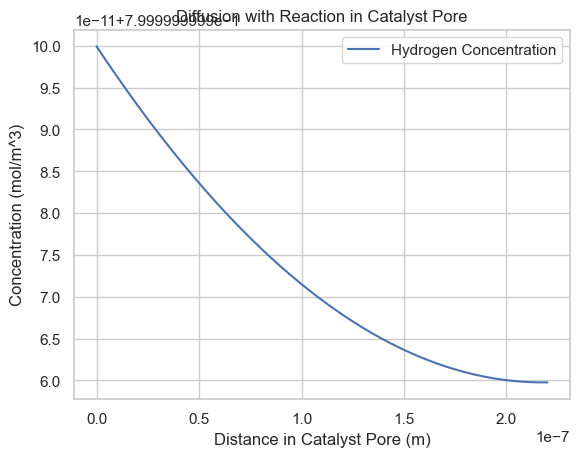

In [492]:
import matplotlib.pyplot as plt

# Example inputs
k_reaction = 1e3 * math.exp(-8600 / (T + 273.15))  # Reaction rate constant [1/h]
C_bulk = 0.8  # Bulk concentration [mol/m^3]

# Call the function
x, C = calculate_h2_pore_concentration(k_reaction=k_reaction, C_bulk=C_bulk)

# Plot the results
plt.plot(x, C, label="Hydrogen Concentration")
plt.xlabel("Distance in Catalyst Pore (m)")
plt.ylabel("Concentration (mol/m^3)")
plt.title("Diffusion with Reaction in Catalyst Pore")
plt.grid(True)
plt.legend()
plt.show()


## Adsorption of hydrogen and FAME to the catalyst surface

Steady state assumption
r_ads = r_reaction = r_des

## Reaction of hydrogen and FAME on the catalyst surface

In [468]:
V_reactor = 120 # [cm3] Reactor volume
t_res_h = V_reactor/V_cm3 # [h] residence time
t_res_min = t_res_h*60 # [min] residence time
t_res_s = t_res_h*3600 # [s] residence time

In [469]:
mass_flowrate = V_cm3*rho_MeOleate/1e3 # [g/h] mass flowrate of MeOleate
mol_flowrate = mass_flowrate/296.5 # [mol/h] molar flowrate of MeOleate
mol_flowrate_s = mol_flowrate/3600 # [mol/s] molar flowrate of MeOleate
C_MethylOleate = mol_flowrate/(V_cm3/1e3) # [mol/L] molar flowrate of MeOleate

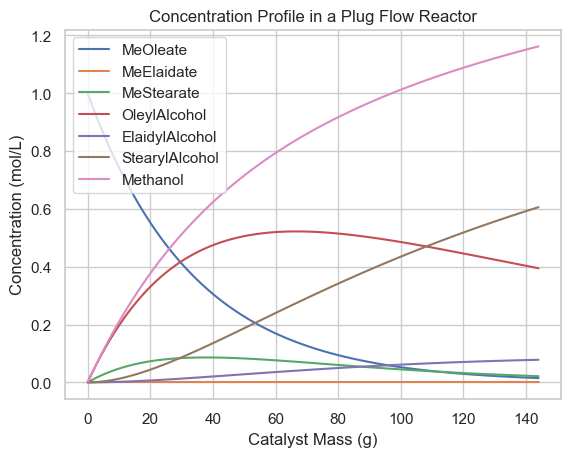

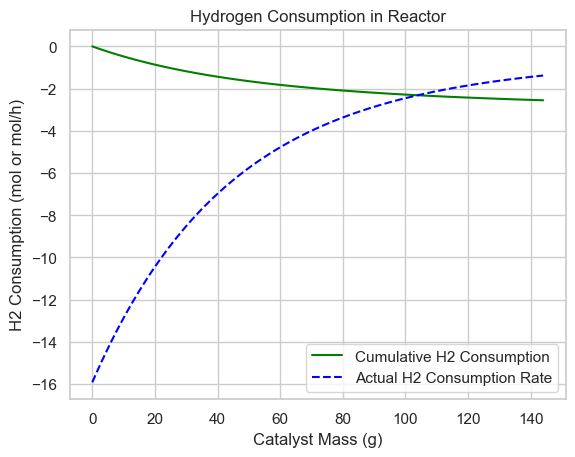

Catalyst Mass (g): [  0.           1.45454545   2.90909091   4.36363636   5.81818182
   7.27272727   8.72727273  10.18181818  11.63636364  13.09090909
  14.54545455  16.          17.45454545  18.90909091  20.36363636
  21.81818182  23.27272727  24.72727273  26.18181818  27.63636364
  29.09090909  30.54545455  32.          33.45454545  34.90909091
  36.36363636  37.81818182  39.27272727  40.72727273  42.18181818
  43.63636364  45.09090909  46.54545455  48.          49.45454545
  50.90909091  52.36363636  53.81818182  55.27272727  56.72727273
  58.18181818  59.63636364  61.09090909  62.54545455  64.
  65.45454545  66.90909091  68.36363636  69.81818182  71.27272727
  72.72727273  74.18181818  75.63636364  77.09090909  78.54545455
  80.          81.45454545  82.90909091  84.36363636  85.81818182
  87.27272727  88.72727273  90.18181818  91.63636364  93.09090909
  94.54545455  96.          97.45454545  98.90909091 100.36363636
 101.81818182 103.27272727 104.72727273 106.18181818 107.63636364

In [486]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define constants
T = 270  # Reaction temperature in Celsius
p_H2 = 230  # [atm] hydrogen pressure
F_0 = 0.1  # [mol/s] Molar flow rate (example value)
epsilon_mean = 0.4  # Mean porosity of the catalyst bed
V_total = 0.120  # Total reactor volume in L
V_total_available = epsilon_mean * V_total  # Available volume in L
V_total_available_m3 = V_total_available * 1e-3  # Convert to m3
catalyst_bulk_density = 1200  # Bulk density of catalyst in kg/m3
W_total = V_total_available_m3 * catalyst_bulk_density  # Total catalyst mass in kg

# Reaction constants
k1 = 1e3 * math.exp(-8600 / (T + 273.15))  # Hydrogenolysis [h^-1 atm^-2]
k2 = 1e9 * math.exp(-13100 / (T + 273.15))  # Hydrogenolysis [h^-1]
k3 = 1.86  # Saturation [h^-1]
k4 = 0.3 * k3  # Isomerization [h^-1]

# Ordered components list
components = [
    "MeOleate", "MeElaidate", "MeStearate", "MePalmitate",
    "OleylAlcohol", "ElaidylAlcohol", "StearylAlcohol",
    "CetylAlcohol", "Methanol", "H2_Consumption"
]

# Initial concentrations in [mol/L]
initial_concentrations = {
    "MeOleate": 1.0, "MeElaidate": 0.0, "MeStearate": 0.0, "MePalmitate": 0.0,
    "OleylAlcohol": 0.0, "ElaidylAlcohol": 0.0, "StearylAlcohol": 0.0,
    "CetylAlcohol": 0.0, "Methanol": 0.0, "H2_Consumption": 0.0  # Track H2 consumption
}

# Reaction definitions (rate expressions)
def reaction_rates(concentrations):
    """Define the reaction rates based on components concentrations."""
    rates = {
        # Hydrogenolysis
        "r_11": k1 * concentrations["MeOleate"] * p_H2**2 - k2 * concentrations["OleylAlcohol"]**2,
        "r_12": k1 * concentrations["MeStearate"] * p_H2**2 - k2 * concentrations["StearylAlcohol"]**2,
        
        # Saturation
        "r_21": k3 * concentrations["MeOleate"],
        "r_22": k3 * concentrations["OleylAlcohol"],
        "r_23": k3 * concentrations["ElaidylAlcohol"],
        
        # Isomerization
        "r_31": k4 * concentrations["OleylAlcohol"]
    }
    return rates

# Define the differential equation system (PFR model)
def pfr_model(V, C):
    # Unpack concentrations into a dictionary for clarity
    concentrations = {components[i]: C[i] for i in range(len(components))}
    rates = reaction_rates(concentrations)
    
    # Differential equations for each component
    dC = {key: 0.0 for key in components}  # Initialize derivatives

    # Define reactions for components
    dC["MeOleate"] = -(rates["r_11"] + rates["r_21"]) / F_0
    dC["MeStearate"] = (rates["r_21"] - rates["r_12"]) / F_0
    dC["OleylAlcohol"] = (rates["r_11"] - rates["r_22"]) / F_0
    dC["ElaidylAlcohol"] = (rates["r_31"] - rates["r_23"]) / F_0
    dC["StearylAlcohol"] = (rates["r_12"] + rates["r_22"] + rates["r_23"]) / F_0
    dC["Methanol"] = (rates["r_11"] + rates["r_22"]) / F_0
    
    # H2 consumption rate
    H2_consumption_rate = -(2 * rates["r_11"] + 2 * rates["r_12"] + rates["r_21"] + rates["r_22"] + rates["r_23"])
    dC["H2_Consumption"] = H2_consumption_rate / F_0  # Track cumulative consumption
    # Convert back to list format for the ODE solver
    return [dC[components[i]] for i in range(len(components))]

# Set up the integration range (reactor volume)
V_range = [0, V_total_available]  # from V=0 to V=V_total_available

# Initial concentrations as a vector
C_0 = [initial_concentrations[sp] for sp in components]

# Solve the ODE system
solution = solve_ivp(
    pfr_model,
    V_range,
    C_0,
    t_eval=np.linspace(0, V_total_available, 100),
    method='RK45'
)

# Map reactor volume to catalyst mass
V_points = solution.t  # Reactor volume points [L]
W_points = (V_points * 1e-3 * catalyst_bulk_density / epsilon_mean) * 1e3  # Catalyst mass points [g]

# Specify which components to plot (excluding H2_Consumption for now)
components_to_plot = ["MeOleate", "MeElaidate", "MeStearate",
    "OleylAlcohol", "ElaidylAlcohol", "StearylAlcohol", "Methanol"]

# Plot the selected components
for sp in components_to_plot:
    idx = components.index(sp)
    plt.plot(W_points, solution.y[idx], label=sp)

plt.xlabel("Catalyst Mass (g)")
plt.ylabel("Concentration (mol/L)")
plt.title("Concentration Profile in a Plug Flow Reactor")
plt.grid(True)
plt.legend()
plt.show()

# Plot H2 consumption (cumulative and actual)
H2_idx = components.index("H2_Consumption")

# Calculate actual H2 consumption rate at each point
H2_consumption_rates = []
for i, V in enumerate(V_points):
    # Concentration at the current point
    concentrations = {components[j]: solution.y[j, i] for j in range(len(components))}
    # Reaction rates at the current point
    rates = reaction_rates(concentrations)
    # Calculate actual H2 consumption rate
    H2_consumption_rate = -(2 * rates["r_11"] + 2 * rates["r_12"] + rates["r_21"] + rates["r_22"] + rates["r_23"])
    H2_consumption_rates.append(H2_consumption_rate)

# Plot cumulative H2 consumption
plt.plot(W_points, solution.y[H2_idx], label="Cumulative H2 Consumption", color='green')

# Plot actual H2 consumption rate
plt.plot(W_points, H2_consumption_rates, label="Actual H2 Consumption Rate", color='blue', linestyle='--')

plt.xlabel("Catalyst Mass (g)")
plt.ylabel("H2 Consumption (mol or mol/h)")
plt.title("Hydrogen Consumption in Reactor")
plt.grid(True)
plt.legend()
plt.show()

# Print numerical results for debugging or analysis
print("Catalyst Mass (g):", W_points)
print("Cumulative H2 Consumption (mol):", solution.y[H2_idx])
print("Actual H2 Consumption Rates (mol/h):", H2_consumption_rates)


In [476]:
# Printed output
c_H2_diss
Re
Sc
Sh
r_H2_total

1.1479477130051923

In [473]:

### Influence of Pellet Geometry on Mean Void Fraction
#Catalyst particle is simplified as a cylinder, where diffusion occurs only towards lateral face.

# Given dimensions
diameter = 3  # in mm
height = 3    # in mm

# Calculate the radius
radius = diameter / 2

# Calculate the area of one end (circular base)
area_end = math.pi * (radius ** 2)

# Calculate the surface area of the cylindrical body
area_body = 2 * math.pi * radius * height

# Calculate the total area of both ends
total_area_ends = 2 * area_end

# Calculate the total surface area of the cylinder
total_surface_area = area_body + total_area_ends

# Print the results
print(f"Radius: {radius:.2f} mm")
print(f"Area of one end: {area_end:.2f} mm2")
print(f"Surface area of the body: {area_body:.2f} mm2")
print(f"Total area of both ends: {total_area_ends:.2f} mm2")
print(f"Total surface area: {total_surface_area:.2f} mm2")

# The particle geometry is then to be simplified as a cylindrical shape, without diffusion on its ends.
# Contribution to the surface is included in elongation of the particle

l_new = total_surface_area/(math.pi*2*radius) # [mm] new length of the particle with compensation for ends

# Particle geometry revisited --> This is with respect to the simplified assumption in the code block before
dp = 0.003  # [m] particle diameter
height = l_new/1e3   # [m]

Radius: 1.50 mm
Area of one end: 7.07 mm2
Surface area of the body: 28.27 mm2
Total area of both ends: 14.14 mm2
Total surface area: 42.41 mm2


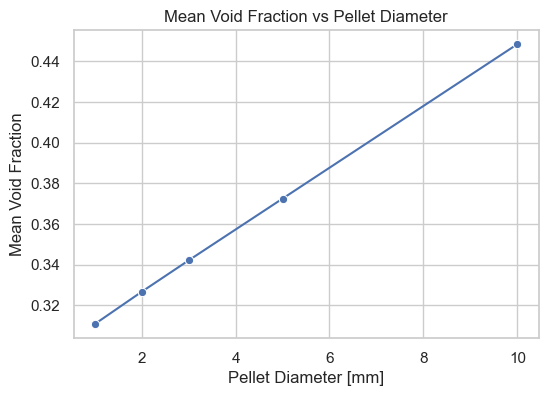

In [474]:
# Define constants for pellet height and tube diameter
h_cp = 0.003  # [m] height cylindrical pellet
d_tube = 0.02  # [m] tube diameter (assuming it's a constant value for analysis)

# Define a list of d_cp values for sensitivity analysis
d_cp_values = [0.001, 0.002, 0.003, 0.005, 0.010]  # You can specify any values you want

# Initialize a list to store the results
results = []

# Loop over the d_cp values
for d_cp in d_cp_values:
    # Recalculate volume of cylindrical pellet and equivalent sphere diameter
    V_cp = math.pi * ((d_cp / 2) ** 2) * h_cp
    d_pe = 2 * (3 * V_cp / (4 * math.pi)) ** (1 / 3)  # [m] equivalent sphere diameter

    # Calculate reduced diameter (dr)
    dr = d_tube / d_pe

    # Calculate epsilon_mean
    epsilon_mean = 0.293 + 0.684 * (dr ** (-0.85)) * (1 / ((1.837 * dr - 1) ** (0.5)))

    # Store the results in the list
    results.append({"d_cp": d_cp, "epsilon_mean": epsilon_mean})

# Convert the results to a Pandas DataFrame
df = pd.DataFrame(results)
df["d_cp"] = df["d_cp"]*1e3 # Conversion from m to mm

# Plotting the results using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.lineplot(x="d_cp", y="epsilon_mean", data=df, marker="o")
plt.title("Mean Void Fraction vs Pellet Diameter")
plt.xlabel("Pellet Diameter [mm]")
plt.ylabel("Mean Void Fraction")
plt.grid(True)
plt.show()

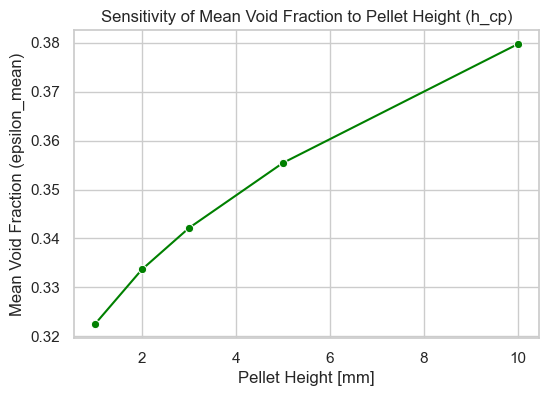

In [475]:
# Influence of pellet height on mean void fraction:
# Define constants for pellet diameter and tube diameter
d_cp = 0.003  # [m] diameter cylindrical pellet (constant for this analysis)
d_tube = 0.02  # [m] tube diameter (assuming it's a constant value for analysis)

# Define a list of h_cp values for sensitivity analysis
h_cp_values = [0.001, 0.002, 0.003, 0.005, 0.010]  # You can specify any values you want

# Initialize a list to store the results
results = []

# Loop over the h_cp values
for h_cp in h_cp_values:
    # Recalculate volume of cylindrical pellet and equivalent sphere diameter
    V_cp = math.pi * ((d_cp / 2) ** 2) * h_cp
    d_pe = 2 * (3 * V_cp / (4 * math.pi)) ** (1 / 3)  # [m] equivalent sphere diameter

    # Calculate reduced diameter (dr)
    dr = d_tube / d_pe

    # Calculate epsilon_mean
    epsilon_mean = 0.293 + 0.684 * (dr ** (-0.85)) * (1 / ((1.837 * dr - 1) ** (0.5)))

    # Store the results in the list
    results.append({"h_cp": h_cp, "epsilon_mean": epsilon_mean})

# Convert the results to a Pandas DataFrame
df = pd.DataFrame(results)
df["h_cp"] = df["h_cp"]*1e3 # Conversion from m to mm

# Plotting the results using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.lineplot(x="h_cp", y="epsilon_mean", data=df, marker="o", color = "green")
plt.title("Sensitivity of Mean Void Fraction to Pellet Height (h_cp)")
plt.xlabel("Pellet Height [mm]")
plt.ylabel("Mean Void Fraction (epsilon_mean)")
plt.grid(True)
plt.show()
